**Homework#2**

In [60]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

In [61]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [62]:
train_images.shape

(60000, 28, 28)

In [63]:
len(train_labels)

60000

In [64]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [65]:
test_images.shape

(10000, 28, 28)

In [66]:
len(test_labels)

10000

In [67]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [68]:
(xr,yr), (xt,yt)= keras.datasets.mnist.load_data()

In [69]:
x= xr[16]
#%%
for i in range(28):
    for j in range(28):
        z= x[i,j]
        print(f'{z:3d}', end='')
    print()

  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 93164211250250194 15  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0 20176253237180180243254214  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0204236135 18  0  0 40242252126  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 69253167  0  0  0  0  0130254223  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 74217 79  0  0  0  0  0 46254231 14  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  8 10  0  0  0  0  0  0 39254254104  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5212254141  0  

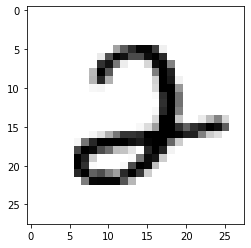

In [70]:
import matplotlib.pyplot as plt
digit = train_images[16]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [71]:
train_labels[16]

2

In [84]:
train_images = train_images.reshape((60000, 28 * 28))

In [85]:
x = np.array([[0., 1.],
             [2., 3.],
             [4., 5.]])
x.shape

(3, 2)

In [86]:
x = x.reshape((6, 1))
x

array([[0.],
       [1.],
       [2.],
       [3.],
       [4.],
       [5.]])

In [87]:
x = np.zeros((300, 20))
x = np.transpose(x)
x.shape

(20, 300)

In [72]:
import tensorflow as tf

class NaiveDense:
    def __init__(self, input_size, output_size, activation):
        self.activation = activation

        w_shape = (input_size, output_size)
        w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
        self.W = tf.Variable(w_initial_value)

        b_shape = (output_size,)
        b_initial_value = tf.zeros(b_shape)
        self.b = tf.Variable(b_initial_value)

    def __call__(self, inputs):
        return self.activation(tf.matmul(inputs, self.W) + self.b)

    @property
    def weights(self):
        return [self.W, self.b]

In [73]:
class NaiveSequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
           x = layer(x)
        return x

    @property
    def weights(self):
       weights = []
       for layer in self.layers:
           weights += layer.weights
       return weights

In [74]:
model = NaiveSequential([
    NaiveDense(input_size=28 * 28, output_size=512, activation=tf.nn.relu),
    NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [75]:
import math

class BatchGenerator:
    def __init__(self, images, labels, batch_size=128):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)

    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

In [76]:
def one_training_step(model, images_batch, labels_batch):
    with tf.GradientTape() as tape:
        predictions = model(images_batch)
        per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
            labels_batch, predictions)
        average_loss = tf.reduce_mean(per_sample_losses)
    gradients = tape.gradient(average_loss, model.weights)
    update_weights(gradients, model.weights)
    return average_loss

In [77]:
learning_rate = 1e-3

def update_weights(gradients, weights):
    for g, w in zip(gradients, weights):
        w.assign_sub(g * learning_rate)

In [78]:
from tensorflow.keras import optimizers

optimizer = optimizers.SGD(learning_rate=1e-3)

def update_weights(gradients, weights):
    optimizer.apply_gradients(zip(gradients, weights))

In [79]:
def fit(model, images, labels, epochs, batch_size=128):
    for epoch_counter in range(epochs):
        print(f"Epoch {epoch_counter}")
        batch_generator = BatchGenerator(images, labels)
        for batch_counter in range(batch_generator.num_batches):
            images_batch, labels_batch = batch_generator.next()
            loss = one_training_step(model, images_batch, labels_batch)
            if batch_counter % 100 == 0:
                print(f"loss at batch {batch_counter}: {loss:.2f}")

In [80]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

fit(model, train_images, train_labels, epochs=10, batch_size=128)

Epoch 0
loss at batch 0: 4.61
loss at batch 100: 2.19
loss at batch 200: 2.19
loss at batch 300: 2.07
loss at batch 400: 2.18
Epoch 1
loss at batch 0: 1.87
loss at batch 100: 1.84
loss at batch 200: 1.81
loss at batch 300: 1.69
loss at batch 400: 1.79
Epoch 2
loss at batch 0: 1.55
loss at batch 100: 1.55
loss at batch 200: 1.49
loss at batch 300: 1.41
loss at batch 400: 1.48
Epoch 3
loss at batch 0: 1.30
loss at batch 100: 1.31
loss at batch 200: 1.23
loss at batch 300: 1.20
loss at batch 400: 1.25
Epoch 4
loss at batch 0: 1.11
loss at batch 100: 1.13
loss at batch 200: 1.04
loss at batch 300: 1.04
loss at batch 400: 1.09
Epoch 5
loss at batch 0: 0.97
loss at batch 100: 1.00
loss at batch 200: 0.90
loss at batch 300: 0.92
loss at batch 400: 0.97
Epoch 6
loss at batch 0: 0.86
loss at batch 100: 0.89
loss at batch 200: 0.81
loss at batch 300: 0.83
loss at batch 400: 0.89
Epoch 7
loss at batch 0: 0.79
loss at batch 100: 0.81
loss at batch 200: 0.73
loss at batch 300: 0.77
loss at batch 40

In [81]:
aModel= keras.Sequential([
    keras.Input(28*28),
    keras.layers.Dense(100),    
    keras.layers.Dense(10)   
    ])

aModel.compile(
    loss=     'sparse_categorical_crossentropy',
    metrics= ['accuracy']
    )

In [82]:
aModel= keras.Sequential([
    keras.Input(28*28),
    keras.layers.Dense(150, activation= 'relu'), 
    keras.layers.Dense(50,  activation= 'relu'), 
    keras.layers.Dense(10,  activation= 'softmax')
    ])

aModel.compile(
    loss=     'sparse_categorical_crossentropy',
    metrics= ['accuracy']
    )

aModel.fit(xr1, yr, 
           epochs= 10, 
           batch_size= 100)

aModel.evaluate(xt1, yt)

Epoch 1/10
600/600 [==============================] - 4s 6ms/step - loss: 1.8346 - accuracy: 0.6619
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 0.7095 - accuracy: 0.8384
Epoch 3/10
600/600 [==============================] - 5s 8ms/step - loss: 0.5212 - accuracy: 0.8845
Epoch 4/10
600/600 [==============================] - 4s 7ms/step - loss: 0.3847 - accuracy: 0.9130
Epoch 5/10
600/600 [==============================] - 4s 7ms/step - loss: 0.3324 - accuracy: 0.9273
Epoch 6/10
600/600 [==============================] - 4s 7ms/step - loss: 0.2876 - accuracy: 0.9354
Epoch 7/10
600/600 [==============================] - 4s 7ms/step - loss: 0.2548 - accuracy: 0.9420
Epoch 8/10
600/600 [==============================] - 4s 6ms/step - loss: 0.2365 - accuracy: 0.9471
Epoch 9/10
600/600 [==============================] - 4s 6ms/step - loss: 0.2301 - accuracy: 0.9490
Epoch 10/10
313/313 [==============================] - 1s 2ms/step - loss: 0.3424 - accuracy: 0.9437

[0.34241023659706116, 0.9437000155448914]

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 150)               117750    
                                                                 
 dense_18 (Dense)            (None, 50)                7550      
                                                                 
 dense_19 (Dense)            (None, 10)                510       
                                                                 
Total params: 125,810
Trainable params: 125,810
Non-trainable params: 0
_________________________________________________________________


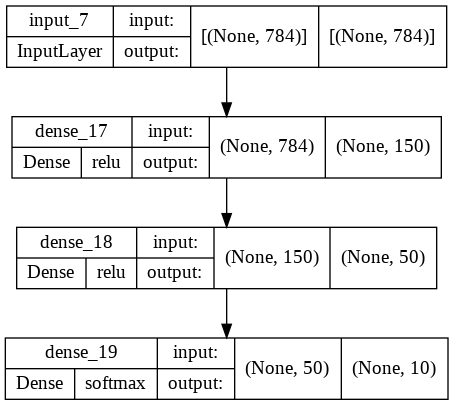

In [83]:
aModel.summary()

keras.utils.plot_model(aModel, 
    show_shapes= True, 
    show_layer_activations= True)